In [28]:
# IMPORT ECO REGION SHAPEFILE
import geopandas as gpd
import pandas as pd

# Load your shapefile
# Replace 'your_shapefile_path.shp' with the actual path to your shapefile
gdf = gpd.read_file('/Users/mbraaksma/Files/base_data/advgeocomp2024/mvp02/TerrestrialEcos')

# Define the eco_names and their observed values from the x-axis of the image
# Replace these with the actual observed values
eco_name_observed_values = {
    'Araucaria moist forests': 0.12,
    'Alto Paraná Atlantic forests': 0.15,
    'Uruguayan savanna': 0.18,
    'Llanos': 0.10,
    'Espinal': 0.08,
    'Humid Pampas': 0.07,
    'Humid Chaco': 0.09,
    'Peten–Veracruz moist forests': 0.05,
    'Chiquitano dry forests': 0.03,
    'Dry Chaco': 0.20,
    'Cerrado': 0.25,
    'Mato Grosso seasonal forests': 0.60
}

# Filter the GeoDataFrame to include only the specified eco_names
subset_gdf = gdf[gdf['ECO_NAME'].isin(eco_name_observed_values.keys())]

# Add a new column 'observed_value' with the corresponding x-axis observed values
subset_gdf['observed_value'] = subset_gdf['ECO_NAME'].map(eco_name_observed_values)


/Users/mbraaksma/mambaforge/envs/geovenv1/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [29]:
subset_gdf.explore()

In [30]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# Load your shapefile subset (filtered GeoDataFrame from previous step)
# Assuming `subset_gdf` already has the 'observed_value' column
# and you've filtered it down to the required eco_name subset.

# Load the template raster file
# Replace 'template_raster_path.tif' with the path to your reference raster file
with rasterio.open('/Users/mbraaksma/Files/base_data/land_supply/aligned/anntotprecip.tif') as src:
    template_meta = src.meta.copy()
    template_shape = src.shape
    template_transform = src.transform

# Prepare geometries and values for rasterization
# Each geometry should have its 'observed_value' mapped to it
shapes = ((geom, value) for geom, value in zip(subset_gdf.geometry, subset_gdf['observed_value']))

# Rasterize using the template raster's shape and transform
rasterized_data = rasterize(
    shapes=shapes,
    out_shape=template_shape,
    transform=template_transform,
    fill=0,  # background value, e.g., 0 for no data
    dtype='float32'  # use a suitable data type
)

# Update metadata to match the output raster
output_meta = template_meta.copy()
output_meta.update({"dtype": 'float32', "count": 1})

# Save the rasterized output to a new file
output_path = '/Users/mbraaksma/Files/base_data/advgeocomp2024/mvp02/rasterized_ecos.tif'
with rasterio.open(output_path, 'w', **output_meta) as dst:
    dst.write(rasterized_data, 1)

print(f"Rasterization complete. Output saved to {output_path}.")


Rasterization complete. Output saved to /Users/mbraaksma/Files/base_data/advgeocomp2024/mvp02/rasterized_ecos.tif.


In [ ]:
import rasterio

for raster_path in base_raster_paths:
    with rasterio.open(raster_path) as src:
        print(f"Raster: {raster_path}")
        print(f"Data type: {src.dtypes[0]}")
        print(f"Width: {src.width}, Height: {src.height}")
        print(f"CRS: {src.crs}")
        print(f"Bounds: {src.bounds}\n")

In [18]:
import os
from osgeo import gdal

# Directory containing your raster files
data_dir = '/Users/mbraaksma/Files/base_data/land_supply'

# Raster paths
base_raster_paths = [
    os.path.join(data_dir, 'anntotprecip/anntotprecip'),
    os.path.join(data_dir, 'builtupland/builtupland'),
    os.path.join(data_dir, 'elevation/elevation'),
    os.path.join(data_dir, 'gl-croplands-geotif/cropland.tif'),
    os.path.join(data_dir, 'HWSD2_RASTER/HWSD2.bil'),
    os.path.join(data_dir, 'irragland/irragland'),
    os.path.join(data_dir, 'minutes_to_market/minutes_to_market_10s.tif'),  # Replacement market access file
    os.path.join(data_dir, 'potentialveg/potveg'),
    os.path.join(data_dir, 'soilcarbon/soilcarbon'),
    os.path.join(data_dir, 'SOILPH/soilph')
]

# Corresponding target paths (ensure all have .tif extension)
target_raster_paths = [
    os.path.join(data_dir, 'aligned/anntotprecip.tif'),
    os.path.join(data_dir, 'aligned/builtupland.tif'),
    os.path.join(data_dir, 'aligned/elevation.tif'),
    os.path.join(data_dir, 'aligned/cropland.tif'),
    os.path.join(data_dir, 'aligned/HWSD2.tif'),
    os.path.join(data_dir, 'aligned/irragland.tif'),
    os.path.join(data_dir, 'aligned/minutes_to_market_10s.tif'),
    os.path.join(data_dir, 'aligned/potentialveg.tif'),
    os.path.join(data_dir, 'aligned/soilcarbon.tif'),
    os.path.join(data_dir, 'aligned/SOILPH.tif')
]

# Create the target directory if it doesn't exist
if not os.path.exists(os.path.join(data_dir, 'aligned')):
    os.mkdir(os.path.join(data_dir, 'aligned'))

# Load the reference raster's resolution and bounding box
template_raster = gdal.Open(os.path.join(data_dir, 'aligned/anntotprecip.tif'))
xRes = template_raster.GetGeoTransform()[1]
yRes = abs(template_raster.GetGeoTransform()[5])
width = template_raster.RasterXSize
height = template_raster.RasterYSize
extent = template_raster.GetGeoTransform()
template_raster = None  # Close the template raster

# Function to align each raster to the reference raster's specs
def align_raster_to_template(target_raster_path, base_raster_path):
    gdal.Warp(
        target_raster_path,
        base_raster_path,
        xRes=xRes,
        yRes=yRes,
        width=width,
        height=height,
        resampleAlg='bilinear',
        outputBounds=[extent[0], extent[3] + height * extent[5], 
                      extent[0] + width * xRes, extent[3]],
        dstSRS='EPSG:4326',
        targetAlignedPixels=True
    )

# Loop through the base rasters and apply the alignment function
for base_raster_path, target_raster_path in zip(base_raster_paths, target_raster_paths):
    # Debugging output for paths
    print(f'Checking: {base_raster_path}')
    
    # Check if the base raster path exists
    if os.path.exists(base_raster_path):  # Check for the folder
        print(f'Processing: {base_raster_path}')
        
        # Align the raster to the template's resolution and extent
        align_raster_to_template(target_raster_path, base_raster_path)
        
        print(f'Successfully created: {target_raster_path}')
    else:
        print(f'Warning: {base_raster_path} does not exist or is not a valid file.')

print("All rasters have been processed.")


Checking: /Users/mbraaksma/Files/base_data/land_supply/anntotprecip/anntotprecip
Processing: /Users/mbraaksma/Files/base_data/land_supply/anntotprecip/anntotprecip
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned/anntotprecip.tif
Checking: /Users/mbraaksma/Files/base_data/land_supply/builtupland/builtupland
Processing: /Users/mbraaksma/Files/base_data/land_supply/builtupland/builtupland
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned/builtupland.tif
Checking: /Users/mbraaksma/Files/base_data/land_supply/elevation/elevation
Processing: /Users/mbraaksma/Files/base_data/land_supply/elevation/elevation
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned/elevation.tif
Checking: /Users/mbraaksma/Files/base_data/land_supply/gl-croplands-geotif/cropland.tif
Processing: /Users/mbraaksma/Files/base_data/land_supply/gl-croplands-geotif/cropland.tif
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned

In [11]:
import os
from osgeo import gdal

# Directory containing your raster files
data_dir = '/Users/mbraaksma/Files/base_data/land_supply'

# Raster paths
base_raster_paths = [
    os.path.join(data_dir, 'anntotprecip/anntotprecip'),
    os.path.join(data_dir, 'builtupland/builtupland'),
    os.path.join(data_dir, 'elevation/elevation'),
    os.path.join(data_dir, 'gl-croplands-geotif/cropland.tif'),
    os.path.join(data_dir, 'HWSD2_RASTER/HWSD2.bil'),
    os.path.join(data_dir, 'irragland/irragland'),
    os.path.join(data_dir, 'minutes_to_market/minutes_to_market_10s.tif'), # replacement market access file
    os.path.join(data_dir, 'potentialveg/potveg'),
    os.path.join(data_dir, 'soilcarbon/soilcarbon'),
    os.path.join(data_dir, 'SOILPH/soilph')
]

# Corresponding target paths (ensure all have .tif extension)
target_raster_paths = [
    os.path.join(data_dir, 'aligned/anntotprecip.tif'),
    os.path.join(data_dir, 'aligned/builtupland.tif'),
    os.path.join(data_dir, 'aligned/elevation.tif'),
    os.path.join(data_dir, 'aligned/cropland.tif'),
    os.path.join(data_dir, 'aligned/HWSD2.tif'),
    os.path.join(data_dir, 'aligned/irragland.tif'),
    os.path.join(data_dir, 'aligned/minutes_to_market_10s.tif'),
    os.path.join(data_dir, 'aligned/potentialveg.tif'),
    os.path.join(data_dir, 'aligned/soilcarbon.tif'),
    os.path.join(data_dir, 'aligned/SOILPH.tif')
]

# Create the target directory if it doesn't exist
if not os.path.exists(os.path.join(data_dir, 'aligned')):
    os.mkdir(os.path.join(data_dir, 'aligned'))

# Loop through the base rasters and apply the gdal.Warp function
for base_raster_path, target_raster_path in zip(base_raster_paths, target_raster_paths):
    # Debugging output for paths
    print(f'Checking: {base_raster_path}')  # Added line for debugging
    
    # Check if the base raster path exists
    if os.path.exists(base_raster_path):  # Check for the folder
        print(f'Processing: {base_raster_path}')
        
        # Using gdal.Warp to reproject and resize
        gdal.Warp(
            target_raster_path,
            base_raster_path,
            xRes=0.7,
            yRes=0.7,
            resampleAlg='bilinear',
            # outputBounds=[-68.5, -17.5, -65.5, -15.5],  # Bounding box around La Paz, Bolivia            
            dstSRS='EPSG:4326'  
        )
        print(f'Successfully created: {target_raster_path}')
    else:
        print(f'Warning: {base_raster_path} does not exist or is not a valid file.')

print("All rasters have been processed.")


Checking: /Users/mbraaksma/Files/base_data/land_supply/anntotprecip/anntotprecip
Processing: /Users/mbraaksma/Files/base_data/land_supply/anntotprecip/anntotprecip
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned/anntotprecip.tif
Checking: /Users/mbraaksma/Files/base_data/land_supply/builtupland/builtupland
Processing: /Users/mbraaksma/Files/base_data/land_supply/builtupland/builtupland
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned/builtupland.tif
Checking: /Users/mbraaksma/Files/base_data/land_supply/elevation/elevation
Processing: /Users/mbraaksma/Files/base_data/land_supply/elevation/elevation
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned/elevation.tif
Checking: /Users/mbraaksma/Files/base_data/land_supply/gl-croplands-geotif/cropland.tif
Processing: /Users/mbraaksma/Files/base_data/land_supply/gl-croplands-geotif/cropland.tif
Successfully created: /Users/mbraaksma/Files/base_data/land_supply/aligned

# NEW ATTEMPT WITH RASTERIZED ECOS

In [32]:
import rasterio
import numpy as np
import os

# Load the 'observed' raster, which will be used as a mask
# observed_raster_path = 'rasterized_output.tif'
data_dir = '../../../base_data/advgeocomp2024/mvp02'
observed_raster_path = os.path.join(data_dir, 'rasterized_ecos.tif')
with rasterio.open(observed_raster_path) as obs_src:
    observed_data = obs_src.read(1)  # Read the single band as a 2D array

# Initialize an empty list to store each raster as an array
raster_arrays = []

# Load each raster in the list and append to raster_arrays
for raster_path in raster_paths:
    with rasterio.open(raster_path) as src:
        raster_arrays.append(src.read(1))  # Read the first band as a 2D array

# Stack all raster arrays into a single 3D array (layers in the 3rd dimension)
stacked_rasters = np.dstack(raster_arrays)  # Shape will be (height, width, num_rasters)


In [37]:
import os
import numpy as np
import tensorflow as tf
from osgeo import gdal
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


In [97]:
def load_raster(raster_path):
    dataset = gdal.Open(raster_path)
    array = dataset.ReadAsArray()
    return array

def load_and_stack_rasters(raster_paths):
    raster_stack = []
    for path in raster_paths:
        array = load_raster(path)
        raster_stack.append(array)
    # Stack along a new axis for CNN input (height, width, channels)
    return np.stack(raster_stack, axis=-1)

# Load all rasters
data_dir = '/Users/mbraaksma/Files/base_data/land_supply'
raster_paths = [
    os.path.join(data_dir, 'aligned/anntotprecip.tif'),
    os.path.join(data_dir, 'aligned/builtupland.tif'),
    os.path.join(data_dir, 'aligned/elevation.tif'),
    os.path.join(data_dir, 'aligned/cropland.tif'),
    os.path.join(data_dir, 'aligned/HWSD2.tif'),
    os.path.join(data_dir, 'aligned/irragland.tif'),
    os.path.join(data_dir, 'aligned/minutes_to_market_10s.tif'),
    os.path.join(data_dir, 'aligned/potentialveg.tif'),
    os.path.join(data_dir, 'aligned/soilcarbon.tif'),
    os.path.join(data_dir, 'aligned/SOILPH.tif')
]
raster_stack = load_and_stack_rasters(raster_paths)


ValueError: all input arrays must have the same shape

Found a valid square area without zero values in the outcome raster.


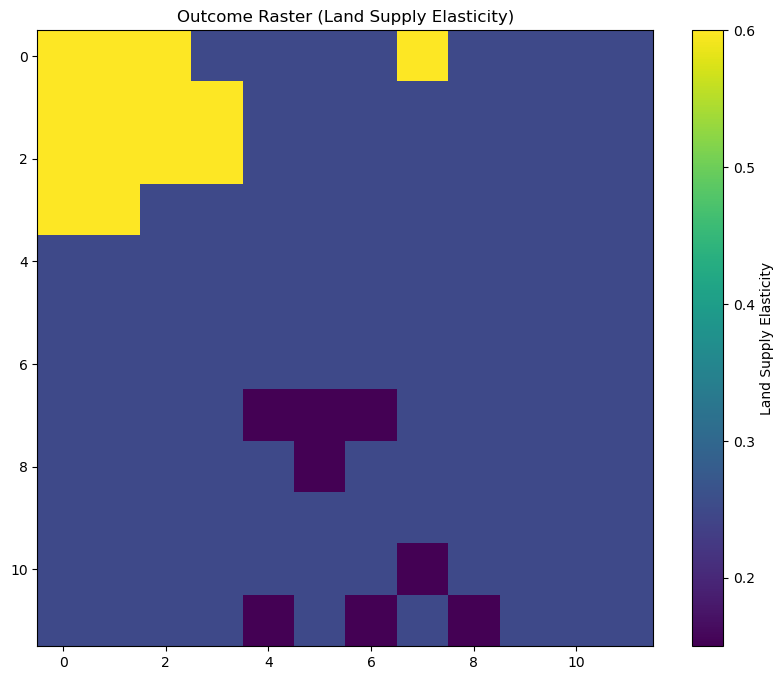

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

def load_raster(raster_path):
    with rasterio.open(raster_path) as src:
        return src.read(1)

def plot_outcome_raster(outcome_raster):
    plt.figure(figsize=(10, 8))
    plt.imshow(outcome_raster, cmap='viridis', vmin=np.min(outcome_raster), vmax=np.max(outcome_raster))
    plt.colorbar(label='Land Supply Elasticity')
    plt.title('Outcome Raster (Land Supply Elasticity)')
    plt.show()

def find_square_with_complete_outcome(outcome_raster, raster_stack, square_size):
    height, width = outcome_raster.shape
    x_max_start = width - square_size
    y_max_start = height - square_size
    
    for y_start in range(0, y_max_start + 1, square_size):
        for x_start in range(0, x_max_start + 1, square_size):
            outcome_square = outcome_raster[y_start:y_start + square_size, x_start:x_start + square_size]
            
            # Treat zeros as "missing" data
            has_missing_data = (outcome_square == 0).any()
            
            if not has_missing_data:
                predictor_square = raster_stack[y_start:y_start + square_size, x_start:x_start + square_size, :]
                return predictor_square, outcome_square
    
    raise ValueError("No square region without zero values in the outcome raster was found.")

# Load and plot the outcome raster
outcome_raster_path = '/Users/mbraaksma/Files/base_data/advgeocomp2024/mvp02/rasterized_ecos.tif'
outcome_raster = load_raster(outcome_raster_path)

# Example usage: Find a 64x64 area without zero values in the outcome
square_size = 12
try:
    predictor_square, outcome_square = find_square_with_complete_outcome(outcome_raster, raster_stack, square_size)
    print("Found a valid square area without zero values in the outcome raster.")
    plot_outcome_raster(outcome_square)
except ValueError as e:
    print(e)


In [96]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming `predictor_squares` and `outcome_squares` are lists of extracted squares
# Stack the predictor squares and outcomes into NumPy arrays for model input
predictor_squares = np.array(predictor_square)  # Shape: (num_samples, square_size, square_size, num_rasters)
outcome_squares = np.array(outcome_square)      # Shape: (num_samples, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictor_squares, outcome_squares, test_size=0.2, random_state=42)

# Define the CNN model architecture
def build_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        
        # Remove one Conv2D and MaxPooling layer to avoid excessive downsampling
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),  # Use global pooling to avoid dimensionality issues
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # Single output for regression
    ])
    return model

# Build the model
input_shape = X_train.shape[1:]  # (square_size, square_size, num_rasters)
model = build_cnn_model(input_shape)

# Compile the model for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Mean Absolute Error: {test_mae}")

# Predict on new data (example)
predictions = model.predict(X_test)


ValueError: Input 0 of layer "conv2d_27" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 12, 10)

In [88]:
print(X_train.shape)


(9, 12, 10)


In [95]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming `predictor_square` and `outcome_square` are lists of extracted squares
predictor_squares = np.array(predictor_square)  # Shape: (num_samples, square_size, square_size, num_rasters)
outcome_squares = np.array(outcome_square)      # Shape: (num_samples, 1)

# Add a channel dimension to predictor_squares if it's missing
predictor_squares = np.expand_dims(predictor_squares, axis=-1)  # Adding channel dimension (if needed)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictor_squares, outcome_squares, test_size=0.2, random_state=42)

# Ensure y_train is 2D (num_samples, 1)
y_train = np.expand_dims(y_train, axis=-1)  # Ensure it's a 2D array (num_samples, 1)

# Define the CNN model architecture
def build_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # Single output for regression
    ])
    return model

# Build the model
input_shape = X_train.shape[1:]  # (square_size, square_size, num_rasters)
model = build_cnn_model(input_shape)

# Compile the model for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
epochs = 8
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Mean Absolute Error: {test_mae}")

# Predict on new data (example)
predictions = model.predict(X_test)


Epoch 1/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - loss: inf - mae: 3354648750477225161937552398425784320.0000 - val_loss: nan - val_mae: nan
Epoch 2/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


ValueError: Cannot take the length of shape with unknown rank.

In [92]:
# Check the range of values in the data
print(np.min(X_train), np.max(X_train))
print(np.min(y_train), np.max(y_train))


-3.4028234663852886e+38 12808.0
0.15 0.6


In [58]:
# Ensure predictor_squares has the correct shape (num_samples, square_size, square_size, num_rasters)
if len(predictor_squares.shape) == 3:  # Case where the channels dimension is missing
    predictor_squares = np.expand_dims(predictor_squares, axis=-1)  # Add a channels dimension if missing

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(predictor_squares, outcome_squares, test_size=0.2, random_state=42)

# Verify input shape before passing to the model
input_shape = X_train.shape[1:]  # Should now be (square_size, square_size, num_rasters)

# Build the model
model = build_cnn_model(input_shape)

# Compile and train the model as before
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Mean Absolute Error: {test_mae}")


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 1, 64)`, `kernel shape=(3, 3, 64, 128)`, `dilation_rate=[1 1]`.

In [ ]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define the input shape as (height, width, channels)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_cnn_model(input_shape)


In [ ]:
# Reshape for model input
X_train = X_train.reshape(-1, 64, 64, X_train.shape[3])
X_test = X_test.reshape(-1, 64, 64, X_test.shape[3])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)


IndexError: index 257 is out of bounds for axis 0 with size 257

## NEW ATTEMPT WITH GLOBAL DATA + MAKS

In [62]:
import numpy as np
import rasterio

# Read the outcome raster (land_supply_elasticity.tif)
outcome_path = '/Users/mbraaksma/Files/base_data/advgeocomp2024/mvp02/rasterized_ecos.tif'
with rasterio.open(outcome_path) as src:
    outcome_data = src.read(1)  # Read the first band (assuming single-band raster)

# Create a mask where outcome data is not zero (valid data)
mask = outcome_data != 0

In [75]:
import os
import tensorflow as tf
import rasterio

# Load all rasters
data_dir = '/Users/mbraaksma/Files/base_data/land_supply'
raster_paths = [
    os.path.join(data_dir, 'aligned/anntotprecip.tif'),
    os.path.join(data_dir, 'aligned/builtupland.tif'),
    os.path.join(data_dir, 'aligned/elevation.tif'),
    os.path.join(data_dir, 'aligned/cropland.tif'),
    os.path.join(data_dir, 'aligned/HWSD2.tif'),
    os.path.join(data_dir, 'aligned/irragland.tif'),
    os.path.join(data_dir, 'aligned/minutes_to_market_10s.tif'),
    os.path.join(data_dir, 'aligned/potentialveg.tif'),
    os.path.join(data_dir, 'aligned/soilcarbon.tif'),
    os.path.join(data_dir, 'aligned/SOILPH.tif')
]

# Stack predictor rasters
predictors = []
for raster_path in raster_paths:
    with rasterio.open(raster_path) as src:
        predictors.append(src.read(1))  # Read the first band

# Convert the list of predictor arrays into a 3D numpy array
predictors = np.stack(predictors, axis=-1)

# Now the predictors shape should be (height, width, num_rasters)
predictors.shape


(257, 514, 10)

In [76]:
import tensorflow as tf

# Custom loss function that masks out the zeros in the outcome data
def masked_mse(y_true, y_pred):
    # Create a mask where y_true is not zero (valid data)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    # Compute the loss only on the valid data
    loss = tf.reduce_sum(mask * tf.square(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

# Build a simple CNN model
def build_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # Single output for regression
    ])
    return model


In [78]:
# Apply the mask to the outcome data and predictors
X_train = predictors[mask]  # Only keep the predictors where outcome data is valid
y_train = outcome_data[mask]  # Only keep the outcome values where data is valid

# Reshape the training data to match the expected input shape for the CNN
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], X_train.shape[3])  # (n_samples, height, width, num_features)


IndexError: tuple index out of range

In [84]:
X_train.shape

(1036, 10)

In [77]:
# Assuming X_train and y_train are already created and shaped correctly
# Reshape X_train to have the batch dimension
X_train_reshaped = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))  # Adding batch dimension

# Now, X_train_reshaped should be of shape (num_samples, height, width, num_rasters)

# Build and compile the CNN model
input_shape = X_train_reshaped.shape[1:]  # (height, width, num_features)
model = build_cnn_model(input_shape)

model.compile(optimizer='adam', loss=masked_mse, metrics=['mae'])

# Train the model
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=10)


IndexError: tuple index out of range

In [68]:
print(X_train.shape)


(9, 12, 10)


## OLD ATTEMPT WITH TENSORFLOW


In [24]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import gdal

# Directory containing your aligned raster files
data_dir = '/Users/mbraaksma/Files/base_data/land_supply/aligned'

# List of paths to aligned rasters
raster_paths = [
    os.path.join(data_dir, 'anntotprecip.tif'),
    os.path.join(data_dir, 'builtupland.tif'),
    os.path.join(data_dir, 'elevation.tif'),
    os.path.join(data_dir, 'cropland.tif'),
    os.path.join(data_dir, 'HWSD2.tif'),
    os.path.join(data_dir, 'irragland.tif'),
    os.path.join(data_dir, 'minutes_to_market_10s.tif'),
    os.path.join(data_dir, 'potentialveg.tif'),
    os.path.join(data_dir, 'soilcarbon.tif'),
    os.path.join(data_dir, 'SOILPH.tif')
]

# Function to load raster data and stack into a 3D array
def load_raster_data(raster_paths):
    data = []
    for path in raster_paths:
        raster = gdal.Open(path)
        array = raster.ReadAsArray()
        data.append(array)
        raster = None
    return np.stack(data, axis=-1)  # Stack along the last axis for (rows, cols, channels)

# Load raster data
raster_data = load_raster_data(raster_paths)
print(f'Raster data shape: {raster_data.shape}')  # Should be (rows, cols, layers)

# Sample visualization of raster layers
def visualize_layers(data, layer_names):
    n_layers = data.shape[-1]
    fig, axes = plt.subplots(1, n_layers, figsize=(3 * n_layers, 4))
    for i in range(n_layers):
        axes[i].imshow(data[:, :, i], cmap='viridis')
        axes[i].set


Raster data shape: (257, 514, 10)


In [25]:
# Flatten the raster data
n_rows, n_cols, n_layers = raster_data.shape
features = raster_data.reshape(-1, n_layers)  # Reshape to (num_pixels, num_layers)

# Dummy target values for demonstration (replace with actual target data)
target_values = np.random.rand(n_rows * n_cols)  # Replace with your actual target data if available

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((features, target_values))
dataset = dataset.batch(64).shuffle(buffer_size=1000)

# Example of iterating through the dataset
for features_batch, target_batch in dataset.take(1):
    print("Features batch shape:", features_batch.shape)
    print("Target batch shape:", target_batch.shape)


Features batch shape: (64, 10)
Target batch shape: (64,)


2024-11-04 15:25:46.549647: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from osgeo import gdal

# List of paths to preprocessed rasters (make sure these are all aligned in terms of resolution and bounding box)
target_raster_paths = [
    os.path.join(data_dir, 'aligned/anntotprecip.tif'),
    os.path.join(data_dir, 'aligned/builtupland.tif'),
    os.path.join(data_dir, 'aligned/elevation.tif'),
    os.path.join(data_dir, 'aligned/cropland.tif'),
    os.path.join(data_dir, 'aligned/HWSD2.tif'),
    os.path.join(data_dir, 'aligned/irragland.tif'),
    os.path.join(data_dir, 'aligned/minutes_to_market_10s.tif'),
    os.path.join(data_dir, 'aligned/potentialveg.tif'),
    os.path.join(data_dir, 'aligned/soilcarbon.tif'),
    os.path.join(data_dir, 'aligned/SOILPH.tif')
]

# Helper function to load raster data
def load_raster_data(raster_paths):
    data = []
    for path in raster_paths:
        raster = gdal.Open(path)
        array = raster.ReadAsArray()
        data.append(array)
        raster = None
    return np.stack(data, axis=0)

# Load raster data to get dimensions and create a placeholder for target values
raster_data = load_raster_data(target_raster_paths)
_, n_rows, n_cols = raster_data.shape

# Example target array (replace with actual elasticity values)
target_values = np.random.rand(n_rows, n_cols)  # Dummy target values

# Custom Dataset class to load raster data
class RasterDataset(Dataset):
    def __init__(self, raster_data, target_values):
        self.data = raster_data
        self.target_values = target_values

    def __len__(self):
        return self.data.shape[1] * self.data.shape[2]  # Each pixel location is a data point

    def __getitem__(self, idx):
        # Calculate row and column from flat index
        row = idx // self.data.shape[2]
        col = idx % self.data.shape[2]
        
        # Extract features for this pixel (all raster layers)
        features = self.data[:, row, col]
        target = self.target_values[row, col]  # Target elasticity value for this pixel

        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

# Initialize dataset and dataloader
dataset = RasterDataset(raster_data, target_values)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [20]:
# Helper function to load raster data and print dimensions
def load_raster_data(raster_paths):
    data = []
    for path in raster_paths:
        raster = gdal.Open(path)
        if raster is None:
            print(f"Error: Could not open {path}")
            continue
        array = raster.ReadAsArray()
        print(f"Loaded {path} with shape {array.shape}")  # Print the dimensions of each raster
        data.append(array)
        raster = None  # Close the raster file
    return np.stack(data, axis=0)

# Example usage
raster_data = load_raster_data(target_raster_paths)
print(f"Final stacked raster data shape: {raster_data.shape}")  # Print the shape of the stacked array


Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/anntotprecip.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/builtupland.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/elevation.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/cropland.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/HWSD2.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/irragland.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/minutes_to_market_10s.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/potentialveg.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/soilcarbon.tif with shape (257, 514)
Loaded /Users/mbraaksma/Files/base_data/land_supply/aligned/SOILPH.tif with shape (257, 514)
Final stacked raster data s

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class ElasticityPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ElasticityPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model with the number of raster layers as input dimension
model = ElasticityPredictor(input_dim=len(target_raster_paths))


In [22]:
# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    running_loss = 0.0
    for features, target in dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(features)
        loss = criterion(predictions.squeeze(), target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training complete.")


Epoch [1/10], Loss: nan
Epoch [2/10], Loss: nan
Epoch [3/10], Loss: nan
Epoch [4/10], Loss: nan
Epoch [5/10], Loss: nan
Epoch [6/10], Loss: nan
Epoch [7/10], Loss: nan
Epoch [8/10], Loss: nan
Epoch [9/10], Loss: nan
Epoch [10/10], Loss: nan
Training complete.


### Explanation of the Steps
- Data Loading: The RasterDataset class loads all rasters into memory and allows for easy indexing by pixel location, treating each pixel as a data point with multiple raster layers as features.
- Model Definition: ElasticityPredictor is a simple feedforward network. The number of input features corresponds to the number of raster layers.
- Training: The training loop iterates over the dataset, calculates predictions, computes the loss, and adjusts weights using backpropagation.
### Adjustments and Extensions
- Model Complexity: For improved predictions, you may consider adding convolutional layers for spatial context or using more advanced architectures.
- Batching: Adjust batch_size and num_epochs based on memory and performance.
- Input Normalization: Normalizing raster data could improve model performance, depending on the variance across the different raster features.

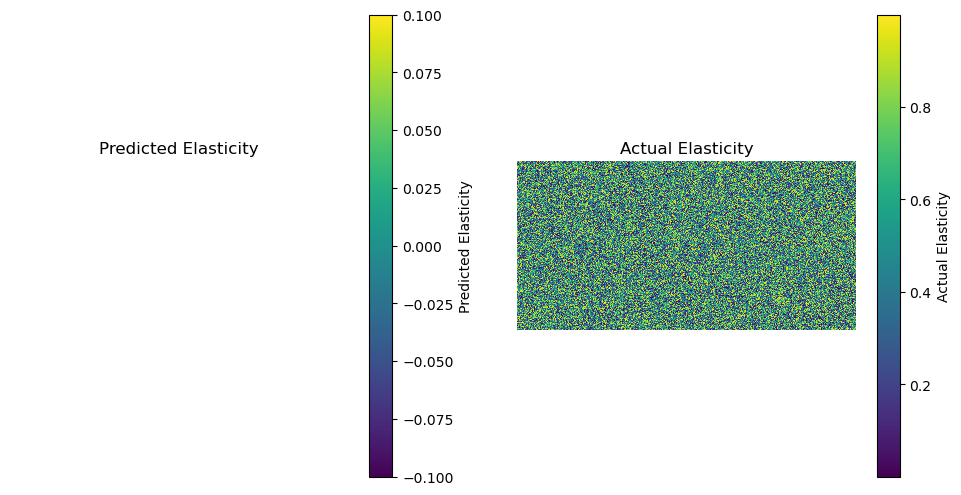

In [23]:
import matplotlib.pyplot as plt
import rasterio

# Function to visualize model predictions against actual values
def plot_predictions(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # No need to compute gradients
        for features, target in dataloader:
            preds = model(features)  # Forward pass to get predictions
            all_preds.append(preds.numpy())
            all_targets.append(target.numpy())

    # Concatenate predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Reshape for visualization
    pred_img = all_preds.reshape(n_rows, n_cols)
    target_img = all_targets.reshape(n_rows, n_cols)

    # Plotting
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Predicted Elasticity')
    plt.title('Predicted Elasticity')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(target_img, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Actual Elasticity')
    plt.title('Actual Elasticity')
    plt.axis('off')

    plt.show()

# Example: After training your model, call this function
plot_predictions(model, dataloader)


OLD ATTEMPT


In [2]:
import torch
from torchgeo.datasets import RasterDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class LandElasticityDataset(RasterDataset):
    def __init__(self, market_access_path, land_suitability_path, transforms=None):
        super().__init__()
        self.add_band(market_access_path, "market_access")
        self.add_band(land_suitability_path, "land_suitability")
        self.transforms = transforms

    def __getitem__(self, index):
        # Load the rasters for the specific index
        sample = super().__getitem__(index)
        
        # Combine bands to create a multi-band tensor
        data = torch.cat([sample["market_access"], sample["land_suitability"]], dim=0)
        
        if self.transforms:
            data = self.transforms(data)
            
        # Here, we're assuming `elasticity` as a regression target
        # For demonstration, let's assign a dummy target (random)
        # Replace this with your actual target if available
        target = torch.tensor([0.5])  # Example: Replace with actual data
        
        return data, target


/Users/mbraaksma/mambaforge/envs/geovenv1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/mbraaksma/mambaforge/envs/geovenv1/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Users/mbraaksma/mambaforge/envs/geovenv1/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/mbraaksma/mambaforge/envs/geovenv1/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/mbraaksma/mambaforge/envs/geovenv1/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/mbraaksma/mambaforge/envs/geovenv1/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/mbraaksma/mambaforge/envs/geovenv1/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no su

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ElasticityPredictorCNN(nn.Module):
    def __init__(self):
        super(ElasticityPredictorCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)  # 2 input channels (market access, land suitability)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # assuming input size 32x32 patches
        self.fc2 = nn.Linear(128, 1)  # output: single elasticity value

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool2d(x, (32, 32))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Define dataset and data loader
dataset = LandElasticityDataset(
    market_access_path="path/to/market_access.tif",
    land_suitability_path="path/to/land_suitability.tif",
    transforms=transforms.Compose([transforms.Normalize(mean=[0.5, 0.5], std=[0.5, 0.5])])
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Instantiate the model, loss function, and optimizer
model = ElasticityPredictorCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {loss.item():.4f}")
    print(f"Epoch {epoch + 1} finished with average loss: {running_loss / len(dataloader):.4f}")

print("Training completed.")


FileNotFoundError: No LandElasticityDataset data was found in `paths='data''`

In [ ]:
import numpy as np
import rasterio

# Set the model to evaluation mode
model.eval()

# Load a sample tile for inference (adjust as needed for full raster processing)
sample_tile = dataset[0][0].unsqueeze(0)  # Load first sample and add batch dimension

# Run inference
with torch.no_grad():
    prediction = model(sample_tile).item()  # Get prediction for a single cell

print(f"Predicted land supply elasticity: {prediction}")

# Save predictions as a raster (placeholder, assuming single-cell for demo)
with rasterio.open("output_elasticity.tif", "w", driver="GTiff", height=1, width=1, count=1, dtype="float32") as dst:
    dst.write(np.array([[prediction]], dtype="float32"), 1)


In [ ]:
import torch
import glob
import os
import rasterio
import numpy as np
from torchgeo.datasets import RasterDataset

# Directory containing the folders with the .adf files
data_folder = "/Users/mbraaksma/Files/base_data/land_supply"

class MultiRasterADFLoader(RasterDataset):
    def __init__(self, data_folder, transforms=None):
        super().__init__()
        
        # Find all subdirectories that contain .adf files
        self.raster_folders = [os.path.dirname(path) for path in glob.glob(os.path.join(data_folder, "**", "w001001.adf"), recursive=True)]
        self.transforms = transforms

    def __getitem__(self, index):
        # Load each raster grid and stack them as separate bands
        bands = []
        for folder in self.raster_folders:
            with rasterio.open(folder) as src:
                # Read the first band (assuming single-band rasters)
                band_data = src.read(1)  # Read as NumPy array
                bands.append(band_data)
        
        # Stack all bands into a 3D tensor (C x H x W format expected by torchgeo)
        data = torch.tensor(np.stack(bands, axis=0), dtype=torch.float32)
        
        if self.transforms:
            data = self.transforms(data)
        
        # Placeholder target (replace with actual target data if available)
        target = torch.tensor([0.5])  # Example: Replace with actual target

        return data, target

# Instantiate the dataset
dataset = MultiRasterADFLoader(data_folder)

# Example: load a single sample
sample_data, target = dataset[0]
print(f"Sample data shape: {sample_data.shape}")
print(f"Target: {target}")


FileNotFoundError: No MultiRasterADFLoader data was found in `paths='data''`

In [ ]:
import torch
import glob
import os
import rasterio
import numpy as np

# Directory containing the folders with the .adf files
data_folder = "/Users/mbraaksma/Files/base_data/land_supply"

class MultiRasterADFLoader:
    def __init__(self, data_folder, transforms=None):
        # Find all subdirectories containing .adf files
        self.raster_folders = [os.path.dirname(path) for path in glob.glob(os.path.join(data_folder, "**", "w001001.adf"), recursive=True)]
        if not self.raster_folders:
            raise FileNotFoundError(f"No raster data found in '{data_folder}'. Make sure the directory structure is correct.")
        self.transforms = transforms

    def __len__(self):
        # Return the number of raster sets (folders)
        return len(self.raster_folders)

    def __getitem__(self, index):
        # Load each raster grid and stack as separate bands
        bands = []
        folder = self.raster_folders[index]
        with rasterio.open(folder) as src:
            band_data = src.read(1)  # Read first band; adjust if multiple bands are present
            bands.append(band_data)

        # Stack all bands into a 3D tensor (C x H x W format)
        data = torch.tensor(np.stack(bands, axis=0), dtype=torch.float32)
        
        if self.transforms:
            data = self.transforms(data)
        
        # Placeholder target (replace with actual target if available)
        target = torch.tensor([0.5])  # Example: Replace with actual target

        return data, target

# Instantiate the dataset
dataset = MultiRasterADFLoader(data_folder)

# Example: load a single sample
sample_data, target = dataset[0]
print(f"Sample data shape: {sample_data.shape}")
print(f"Target: {target}")


Sample data shape: torch.Size([1, 360, 720])
Target: tensor([0.5000])
